<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-оценка-данных" data-toc-modified-id="Загрузка-и-оценка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и оценка данных</a></span></li><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обработка текста</a></span></li><li><span><a href="#Векторизация-текста." data-toc-modified-id="Векторизация-текста.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Векторизация текста.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Пассивно-агрессивный-классификатор" data-toc-modified-id="Пассивно-агрессивный-классификатор-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Пассивно-агрессивный классификатор</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

# Обучение модели классификации комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**План работы**

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Оценить качество моделей
4. Сделать выводы.

**Описание данных**

Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка и оценка данных

Загрузим требуемые библиотеки.

In [ ]:
import numpy as np
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

Загрузим данные

In [ ]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

Посмотрим на данные в датасете, загрузим общую информацию, проверим на пропуски и дубликаты.

In [ ]:
df.head(15)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

Датасет содержит 159292 строки с данными. Пропусков и дубликатов не обнаружено.

В столбце *text* содержится не очищенный текст комметариев.

Мы видим что в столбце *toxic* содержится оценка токсичности комментариев, где 1 - токсичный текст, а 0 - не токсичный.

Перед нами стоит задача бинарной классификации, оценим баланс классов в столбце.

In [ ]:
#выведем процентное соотношение значий в столбце
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Построим график для наглядности

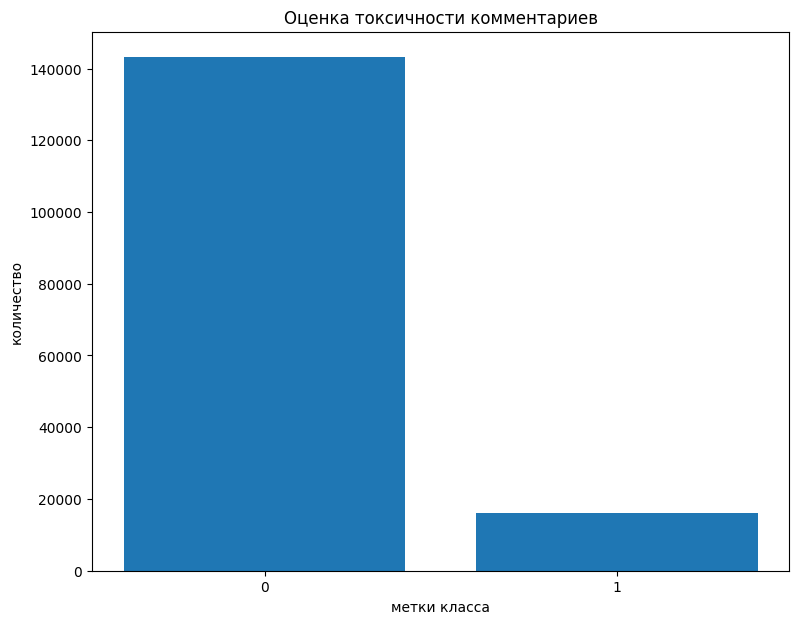

In [ ]:
y = df['toxic'].value_counts()
x = y.index
plt.figure(figsize=[9,7])
plt.bar(x, y)
plt.xlabel('метки класса')
plt.xticks(x)
plt.ylabel('количество')
plt.title('Оценка токсичности комментариев')
plt.show()

Мы видим, что присутствует дисбаланс классов, класс 1 - составляет 10.16% от всех значений.

### Обработка текста

Для обработки текстовых комментариев используем NLP библиотеку Spaсy, она позволит привести слова к леммам и очистить текст от стоп-слов.

Используем предобученную модель для английского языка.

In [ ]:
nlp = spacy.load("en_core_web_sm")

Приведем весь текст к нижнему регистру.

In [ ]:
pd.options.mode.chained_assignment = None
df['text'] = df['text'].str.lower()

Удалим все знаки препинания из текста, сохраним комментарии в новом столбце.

In [ ]:
pd.options.mode.chained_assignment = None
df['words'] = df['text'].apply(lambda row: " ".join(
    (re.sub(r'[^\w\s]',' ', row)).split()))

Загрузим словарь стоп-слов из библиотеки Spacy.

In [ ]:
stop_words = nlp.Defaults.stop_words

Приведем слова к леммам, исключая стоп-слова.

In [ ]:
%%time
pd.options.mode.chained_assignment = None
tqdm.pandas()
df['words'] = df['words'].progress_apply(lambda row: " ".join(
    [w.lemma_ for w in nlp(row) if not w in stop_words]))

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 48min 46s, sys: 20.7 s, total: 49min 7s
Wall time: 50min 11s


Выведем первые 5 строк датафрейма, оценим результат.

In [ ]:
df.head(5)

,text,toxic,words
0,explanation\nwhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour I m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man I m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more I can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...


В столбце *words* сохранен очищенный и лемматизированный текст.

Построим облако слов для не токсичных комментариев

<function matplotlib.pyplot.show(close=None, block=None)>

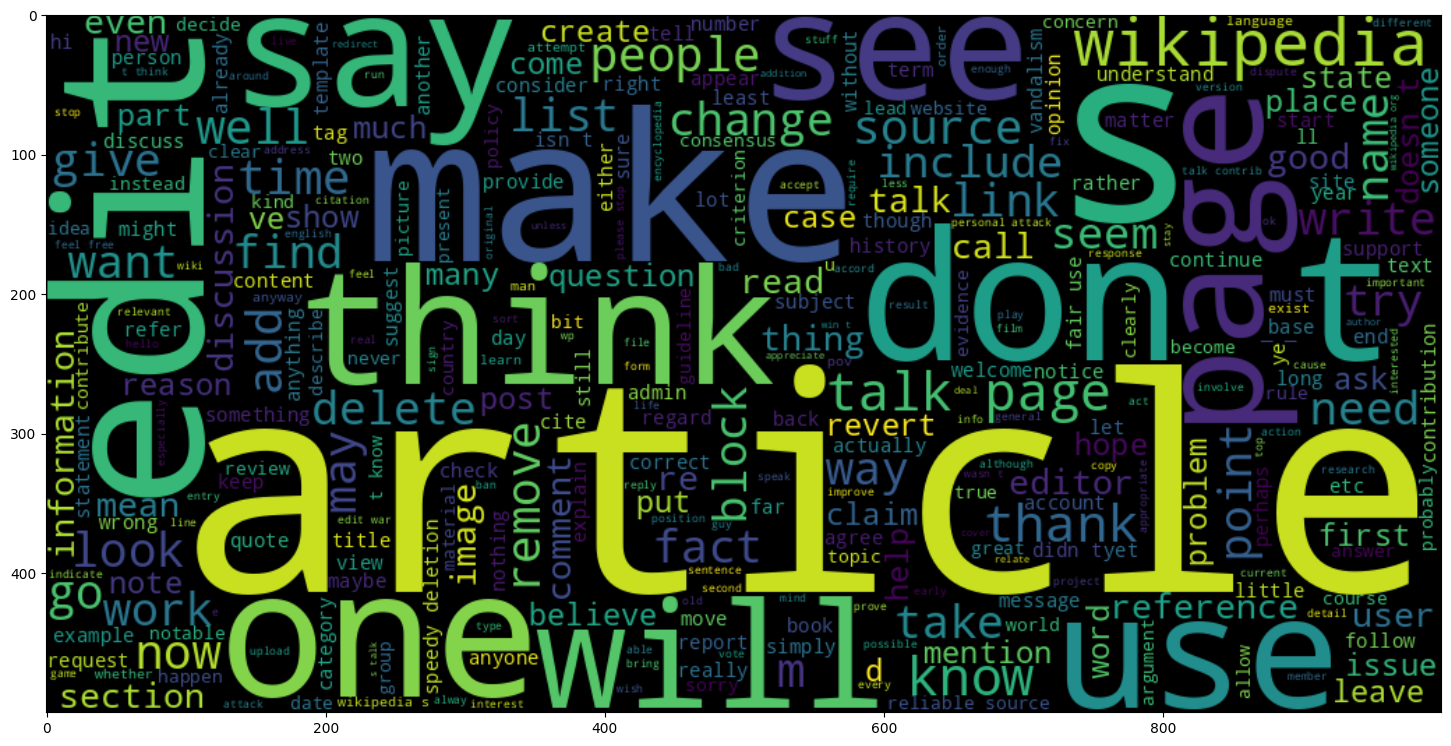

In [ ]:
notoxic_comment = df.query('toxic == 0')

plt.figure(figsize=(18,18))
text = ' '.join(notoxic_comment['words'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show

Построим аналогичное облако для токсичных комментариев

<function matplotlib.pyplot.show(close=None, block=None)>

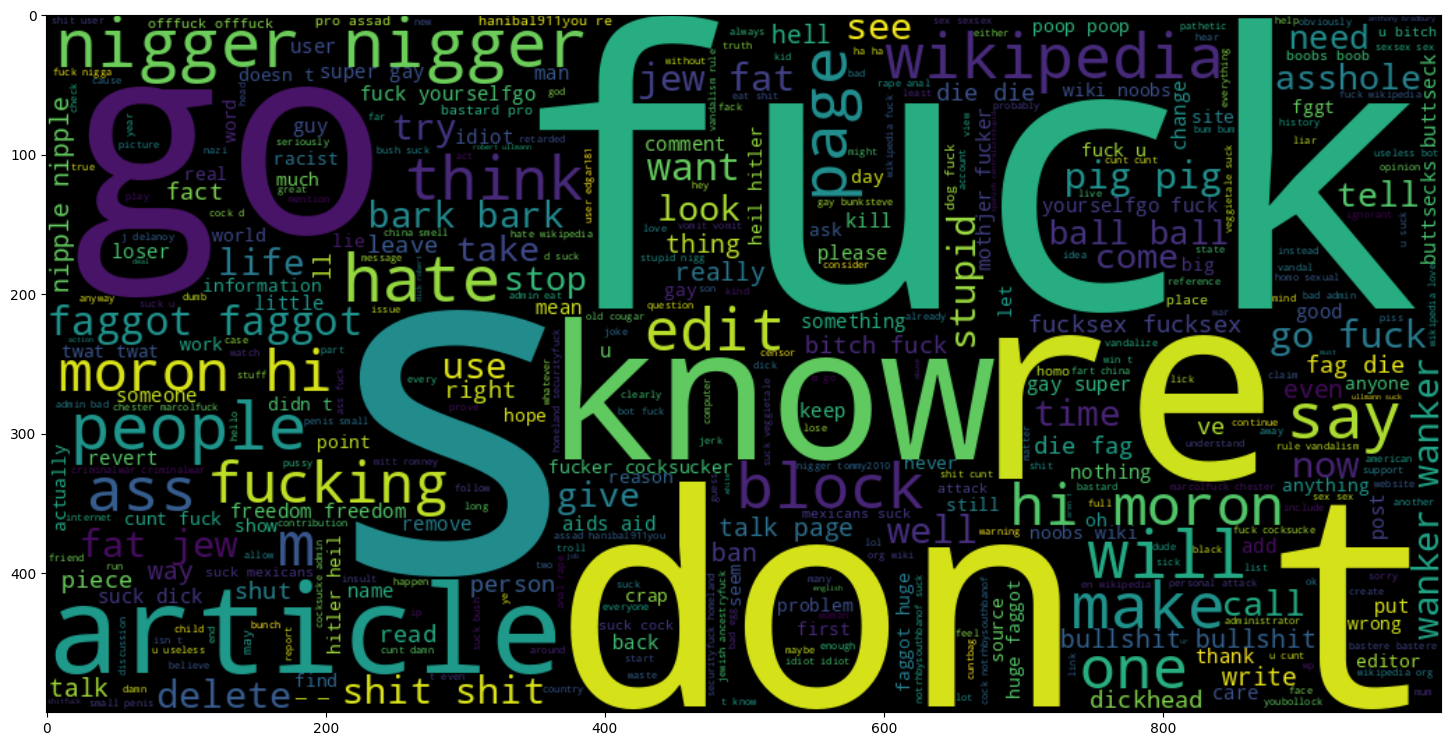

In [ ]:
toxic_comment = df.query('toxic == 1')

plt.figure(figsize=(18,18))
text = ' '.join(toxic_comment['words'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show

Построив облака слов для двух видов комментариев мы видим что, самое популярное слово в не токсичных комментариях - *article*, а в токсичных *fuck*.

### Векторизация текста.

Перед векторизацией текста разделим датафрейм на обучающую и тестовую выборки.

Для тестовой выборки оставим 10% данных.

Используем параметр *stratify* для метода *train_test_split* это позволит сохранить соотношение классов целевого признака.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    df['words'], df['toxic'],stratify= df['toxic'], test_size=0.1, random_state =12345)

Проверим размеры выборок и соотношение классов.

In [ ]:
features_train.shape, features_test.shape

((143362,), (15930,))

In [ ]:
target_train.value_counts(normalize=True), target_test.value_counts(normalize=True)

(0    0.89839
 1    0.10161
 Name: toxic, dtype: float64,
 0    0.898368
 1    0.101632
 Name: toxic, dtype: float64)

Выборки имеют правильный размер и соотношение классов.

Для векторизации текстов используем *TfidfVectorizer*.

In [ ]:
vectorizer_tf = TfidfVectorizer(ngram_range=(1, 1),
                                max_df=0.9,
                                binary = True,
                                norm = 'l2',
                                min_df=0.00001,
                                )

Преобразуем обучающую и тестовые выборки

In [ ]:
features_train_tf = vectorizer_tf.fit_transform(features_train)

In [ ]:
features_test_tf = vectorizer_tf.transform(features_test)

При подготовке данных для обучения моделей, предприняли следующее шаги:

- очистили и лемматизировали тексты комментариев
- выявили дисбаланс классов
- разделили датасет на выборки
- провели векторизацию текстов

Перейдем к построению моделей.

## Обучение

Обучим модели логистической регрессии и случайного леса и пассивно-агрессивный классификатор, проверим их кросс-валидацией.

Для оценки качества моделей используем метрику F1, среднее гармоническое значение точности и полноты. Она позволяет оценить баланс между точностью и полнотой модели и сообщает, насколько точен классификатор.

Дополнительно построим матрицу ошибок.

### Логистическая регрессия

Обучим модель с учетом дисбаланса классов.

In [ ]:
model_linear =LogisticRegression(class_weight='balanced', solver="saga", max_iter=100000, random_state =12345)

Проверим модель с помощью кросс-валидации.

In [ ]:
%%time

scores = cross_val_score(
    model_linear, features_train_tf, target_train, scoring = 'f1', cv=3)
final_score = pd.Series(scores).mean()
final_score

CPU times: user 1min 2s, sys: 152 ms, total: 1min 2s
Wall time: 1min 3s


0.7495231012809164

Значение метрики F1 составило 74.95

Обучим модель на обучающей выборке.

In [ ]:
%%time
model_linear.fit(features_train_tf, target_train)

CPU times: user 22.7 s, sys: 28 ms, total: 22.7 s
Wall time: 22.7 s


LogisticRegression(class_weight='balanced', max_iter=100000, random_state=12345,
                   solver='saga')

### Случайный лес

Обучим модель случайного леса, подберем гиперпараметры методом RandomizedSearchCV.

In [ ]:
%%time
model_random = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 100, 10),
              'max_depth': range (1,13, 2),
              'min_samples_split': range (2,10,2),
              'random_state':[12345],
              'class_weight':['balanced']}

grid = RandomizedSearchCV(model_random, parametrs, cv=3,scoring='f1')
model_grid = grid.fit(features_train_tf, target_train)

print('Параметры лучшей модели:', model_grid.best_params_)
print('F1 мера:', model_grid.best_score_)

Параметры лучшей модели: {'random_state': 12345, 'n_estimators': 80, 'min_samples_split': 6, 'max_depth': 11, 'class_weight': 'balanced'}
F1 мера: 0.3521959297798001
CPU times: user 2min 20s, sys: 1.43 s, total: 2min 22s
Wall time: 2min 22s


Значение метрики F1 для случайного леса составило 35.21

### Пассивно-агрессивный классификатор

Обучим модель с учетом дисбаланса классов и проверим на кросс-валидации.

In [ ]:
model_pac = PassiveAggressiveClassifier(max_iter=2000, random_state =12345)
scores = cross_val_score(
    model_pac, features_train_tf, target_train, scoring = 'f1', cv=3)
final_score = pd.Series(scores).mean()
final_score

0.7512160718779243

In [ ]:
model_pac.fit(features_train_tf, target_train)

PassiveAggressiveClassifier(max_iter=2000, random_state=12345)

Значение метрики F1 для классификатора составило 75.12

Модель пассивно-агрессивного классификатора показала лучший результ.

Проверим её на тестовой выборке.

In [ ]:
predicted_test = model_pac.predict(features_test_tf)
f1_score(target_test,predicted_test)

0.7768649359185015

Для тестовой выборки F1 мера составила 77.68


Построим матрицу ошибок для предсказаний на тестовой выборке.

In [ ]:
confusion_matrix(target_test, predicted_test)

array([[14069,   242],
       [  437,  1182]])

Из матрицы видно, что большая часть ответов проходится на True Negative и True Positive. Модель хорошо предсказывает оба класса текстов.

## Выводы

Этап подготовки данных включил в себя:

- очистку и лемматизацию текстов комментариев
- выявление дисбаланса классов
- векторизацию текстов

Для оценки качества моделей использована метрику F1, среднее гармоническое значение точности и полноты. Она позволила оценить насколько точен классификатор.

Модель логистической регрессии с применением взвешивания классов показала результат F1 меры в 77.68 для тестовой выборки.

Можно считать что у модели хорошая доля истинно положительных и истинно отрицательных ответов и хорошее качество.

**Направления дальнейшего развития проекта**


В работе над проектом не исполльзовались классические методы машинного обучения. Работу с текстами можно проводить также с помощью нейронных сетей, таких как BERT, но этот метод предъявляет высокие технические требования к оборудованию и мной не использовался